In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from scipy.stats import entropy
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

In [14]:
lobster_data = np.load('vwap.npy')

indices = np.arange(lobster_data.shape[0])
np.random.shuffle(indices)
lobster_data = lobster_data[indices]
pct_changes = np.diff(lobster_data, axis=1) / lobster_data[:, :-1]

PCT_Prices = pct_changes[:,:100]

In [142]:
token_limit = 0.02

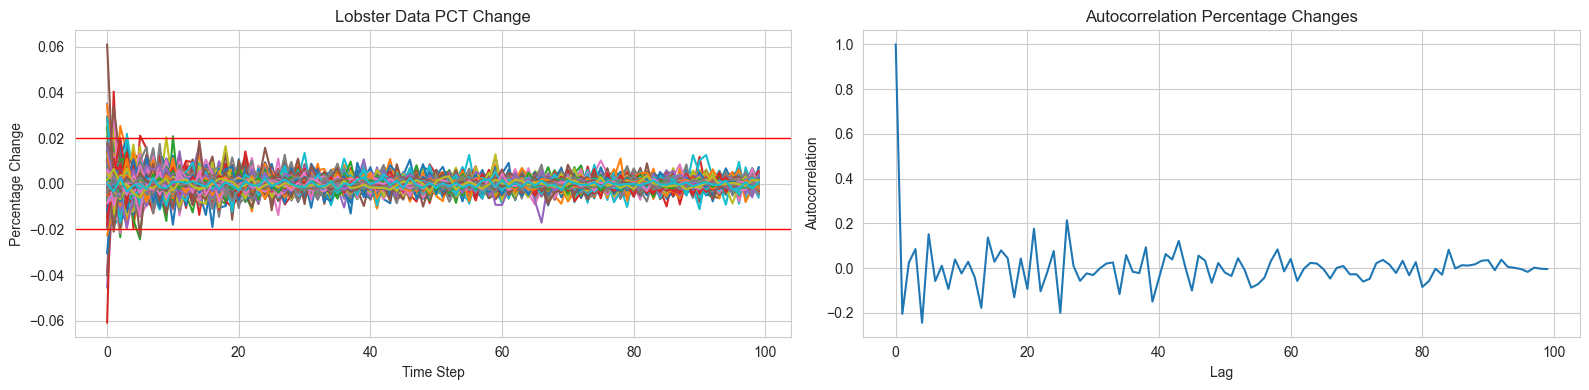

In [143]:
acf_values = acf(PCT_Prices[0], nlags=100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax1.plot(PCT_Prices[:10000].T)
ax1.axhline(token_limit, color='red', linewidth=1)
ax1.axhline(-token_limit, color='red', linewidth=1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Percentage Change')
ax1.set_title('Lobster Data PCT Change')

ax2.plot(range(len(acf_values)), acf_values)
ax2.set_title('Autocorrelation Percentage Changes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

In [144]:
def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path, weights_only=False)
    temp_supervised.load_state_dict(saved_weights['model_state_dict'])
    
    print("Loaded saved supervised weights successfully")
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


In [161]:
def plot_price_hist(time_series, bin_start, bin_stop, bin_width, token_limit):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1, ax2, ax3, ax4 = axes.ravel()
    

    # Histogram
    ax1.plot(time_series.T)
    ax1.axhline(token_limit, color='red', linewidth=1)
    ax1.axhline(-token_limit, color='red', linewidth=1)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Percentage Change')
    ax1.set_title('Time Series')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Boxplot Time Series
    ax2.boxplot(np.concatenate(time_series), vert=True)
    ax2.set_title('Boxplot PCT Change')
    ax2.set_ylabel('Percentage Change')


    # Histogram
    ax3.hist(np.concatenate(time_series), 
                bins=bins, 
                edgecolor='blue', color='orange', density=True)
    ax3.set_title('Histogram: Lobster Data PCT Change')
    ax3.set_xlabel('PCT Change')
    ax3.set_ylabel('Frequency')

    ax4.hist(np.concatenate(time_series), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    ax4.set_xlim(np.quantile(np.concatenate(time_series), q=0.005),np.quantile(np.concatenate(time_series), q=0.995))
    ax4.set_title('Histogram: 99% of Data')
    ax4.set_xlabel('PCT Change')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()  

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(12, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()


def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_sequence_metrics(ep_rew, wasserstein, kl_div):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(wasserstein, color='blue')
    axs[1].set_title('Wasserstein Distance')
    axs[1].set_ylabel('WS Distance')
    axs[1].set_xlabel('Model Update')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(disc_loss, disc_acc, disc_acc_diff):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(disc_loss, color='blue')
    axs[0].set_title('Discriminator Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='lightblue')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1.5)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1.0)

    axs[2].plot(disc_acc_diff, color='blue')
    axs[2].set_title('Accuracy difference: First vs. Second half of Sequence')
    axs[2].set_ylabel('Accuracy Difference')
    axs[2].set_xlabel('Episode')
    
    plt.show()


def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # Plot 1: Variance Distribution
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def plot_sequences(real_seq, supervised, gail):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 125)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, supervised, gail):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    
    supervised_acfs = calculate_acf([supervised[i] for i in range(len(supervised))], nlags=nlags_acf)
    avg_supervised_acf = np.mean(supervised_acfs, axis=0)

    gail_acfs = calculate_acf([gail[i] for i in range(len(gail))], nlags=nlags_acf)
    avg_gail_acf = np.mean(gail_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    
    supervised_pacfs = calculate_pacf([supervised[i] for i in range(len(supervised))], nlags=nlags_pacf)
    avg_supervised_pacf = np.mean(supervised_pacfs, axis=0)

    gail_pacfs = calculate_pacf([gail[i] for i in range(len(gail))], nlags=nlags_pacf)
    avg_gail_pacf = np.mean(gail_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='blue')
    axs[0].plot(avg_supervised_acf, label='Supervised', color='red')
    axs[0].plot(avg_gail_acf, label='GAIL', color='green')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='blue')
    axs[1].plot(avg_supervised_pacf, label='Supervised', color='red')
    axs[1].plot(avg_gail_pacf, label='GAIL', color='green')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution_strong_contrast(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()


In [162]:
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(PCT_Prices)),7))

Standard Deviation of Price Deltas: 0.0011486


In [163]:
bin_width = np.std(np.concatenate(PCT_Prices)) / 8
bin_start=-token_limit
bin_stop=token_limit
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

token_data = tokenize_deltas(PCT_Prices, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

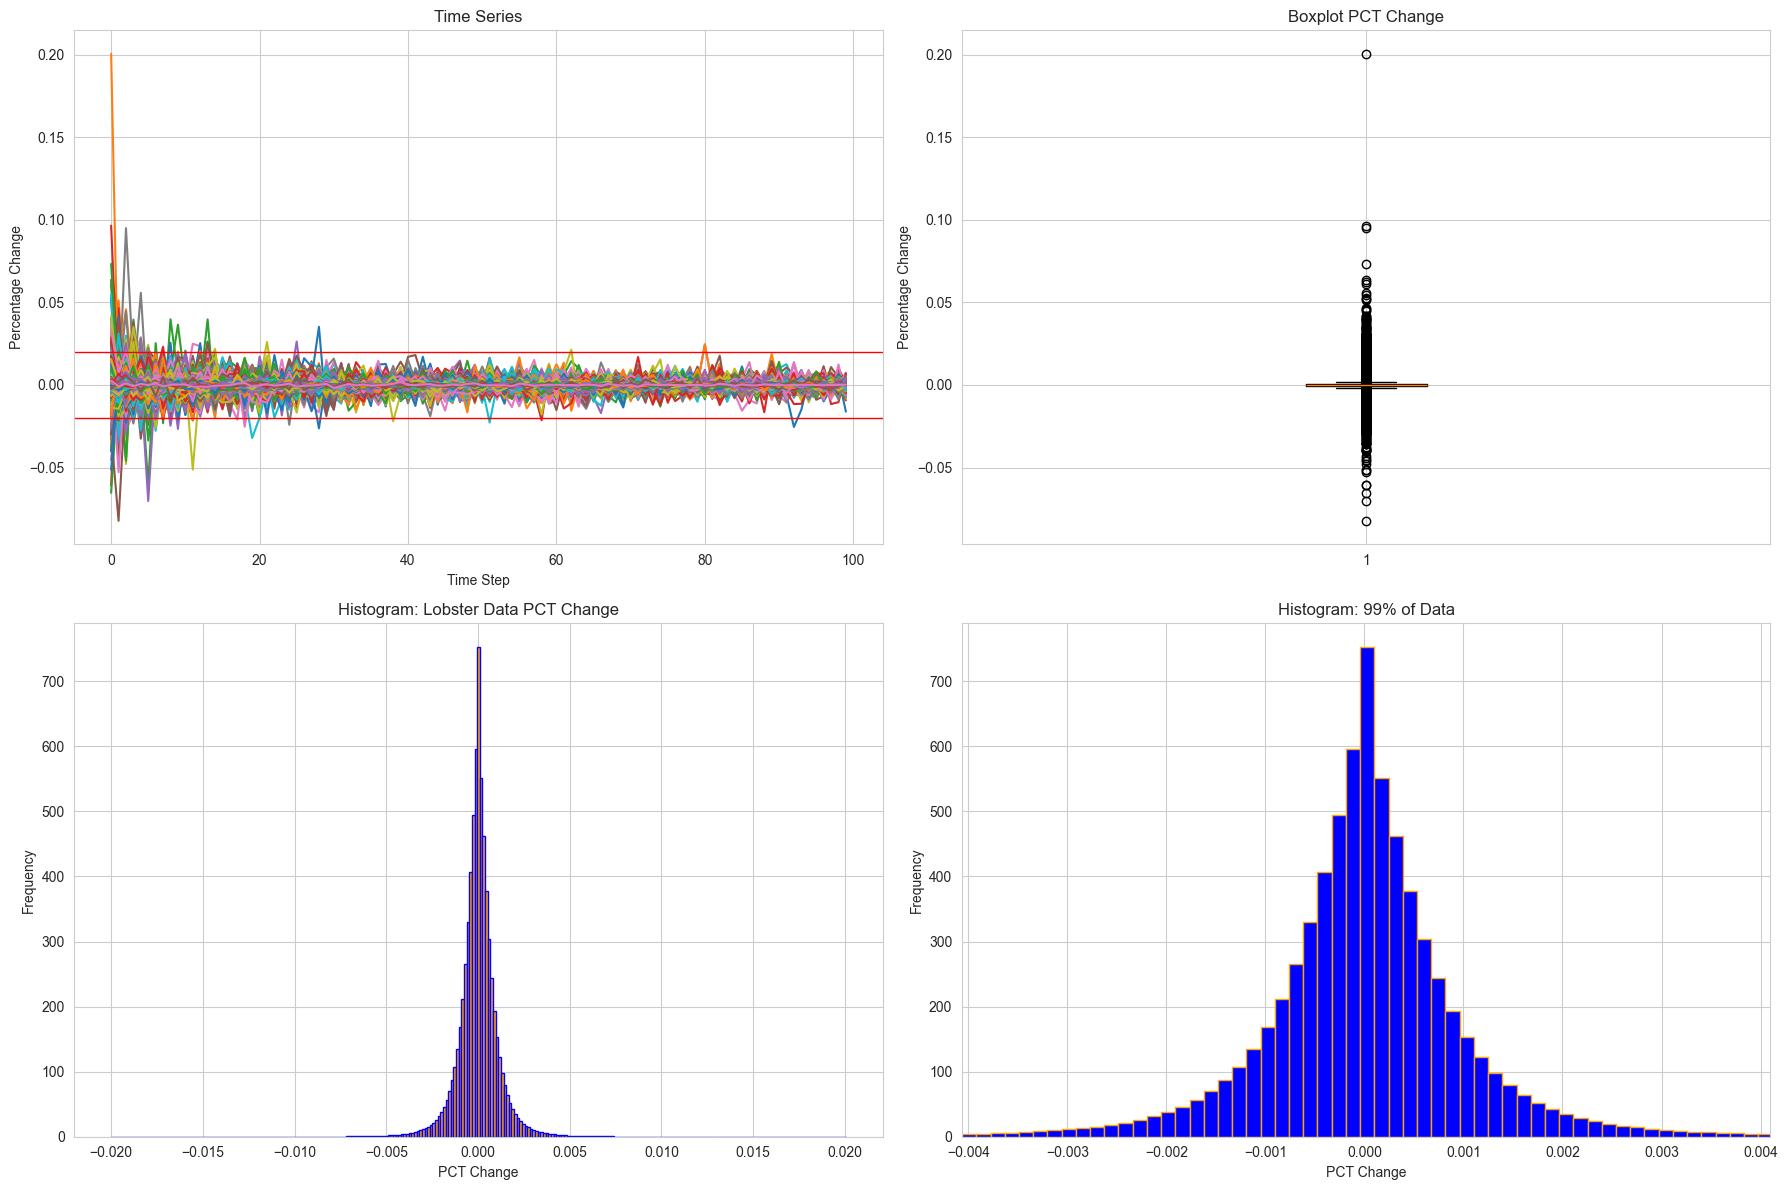

Number of Tokens: 278
Data Shape: (98087, 100)


In [165]:
plot_price_hist(time_series=PCT_Prices, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width, token_limit=token_limit)

print('Number of Tokens:', token_size)
print('Data Shape:', PCT_Prices.shape)